Import Modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np

import pandas as pd

import seaborn as sb
sb.set_context("notebook", font_scale=1)

from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split

import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

Define variables

In [3]:
qualities_to_drop = [3, 4, 6, 8]
features_to_drop = ['fixed acidity', 'volatile acidity', 'citric acid', 'density', 'total sulfur dioxide']
threshold = 5
# learning_rate = 0.02
learning_rate = 0.01
batch_size = 120

Load the data

In [4]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')

Trim outliers.

In [5]:
def outliers(df, threshold, columns):
    for col in columns: 
        mask = df[col] > float(threshold)*df[col].std()+df[col].mean()
        df.loc[mask == True,col] = np.nan
        mean_property = df.loc[:,col].mean()
        df.loc[mask == True,col] = mean_property
    return df

In [6]:
column_list = red_wine.columns.tolist()

In [7]:
print(column_list)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [8]:
red_wine_cleaned = red_wine.copy()
red_wine_cleaned = outliers(red_wine_cleaned, threshold, column_list[0:-1])

Plot Data

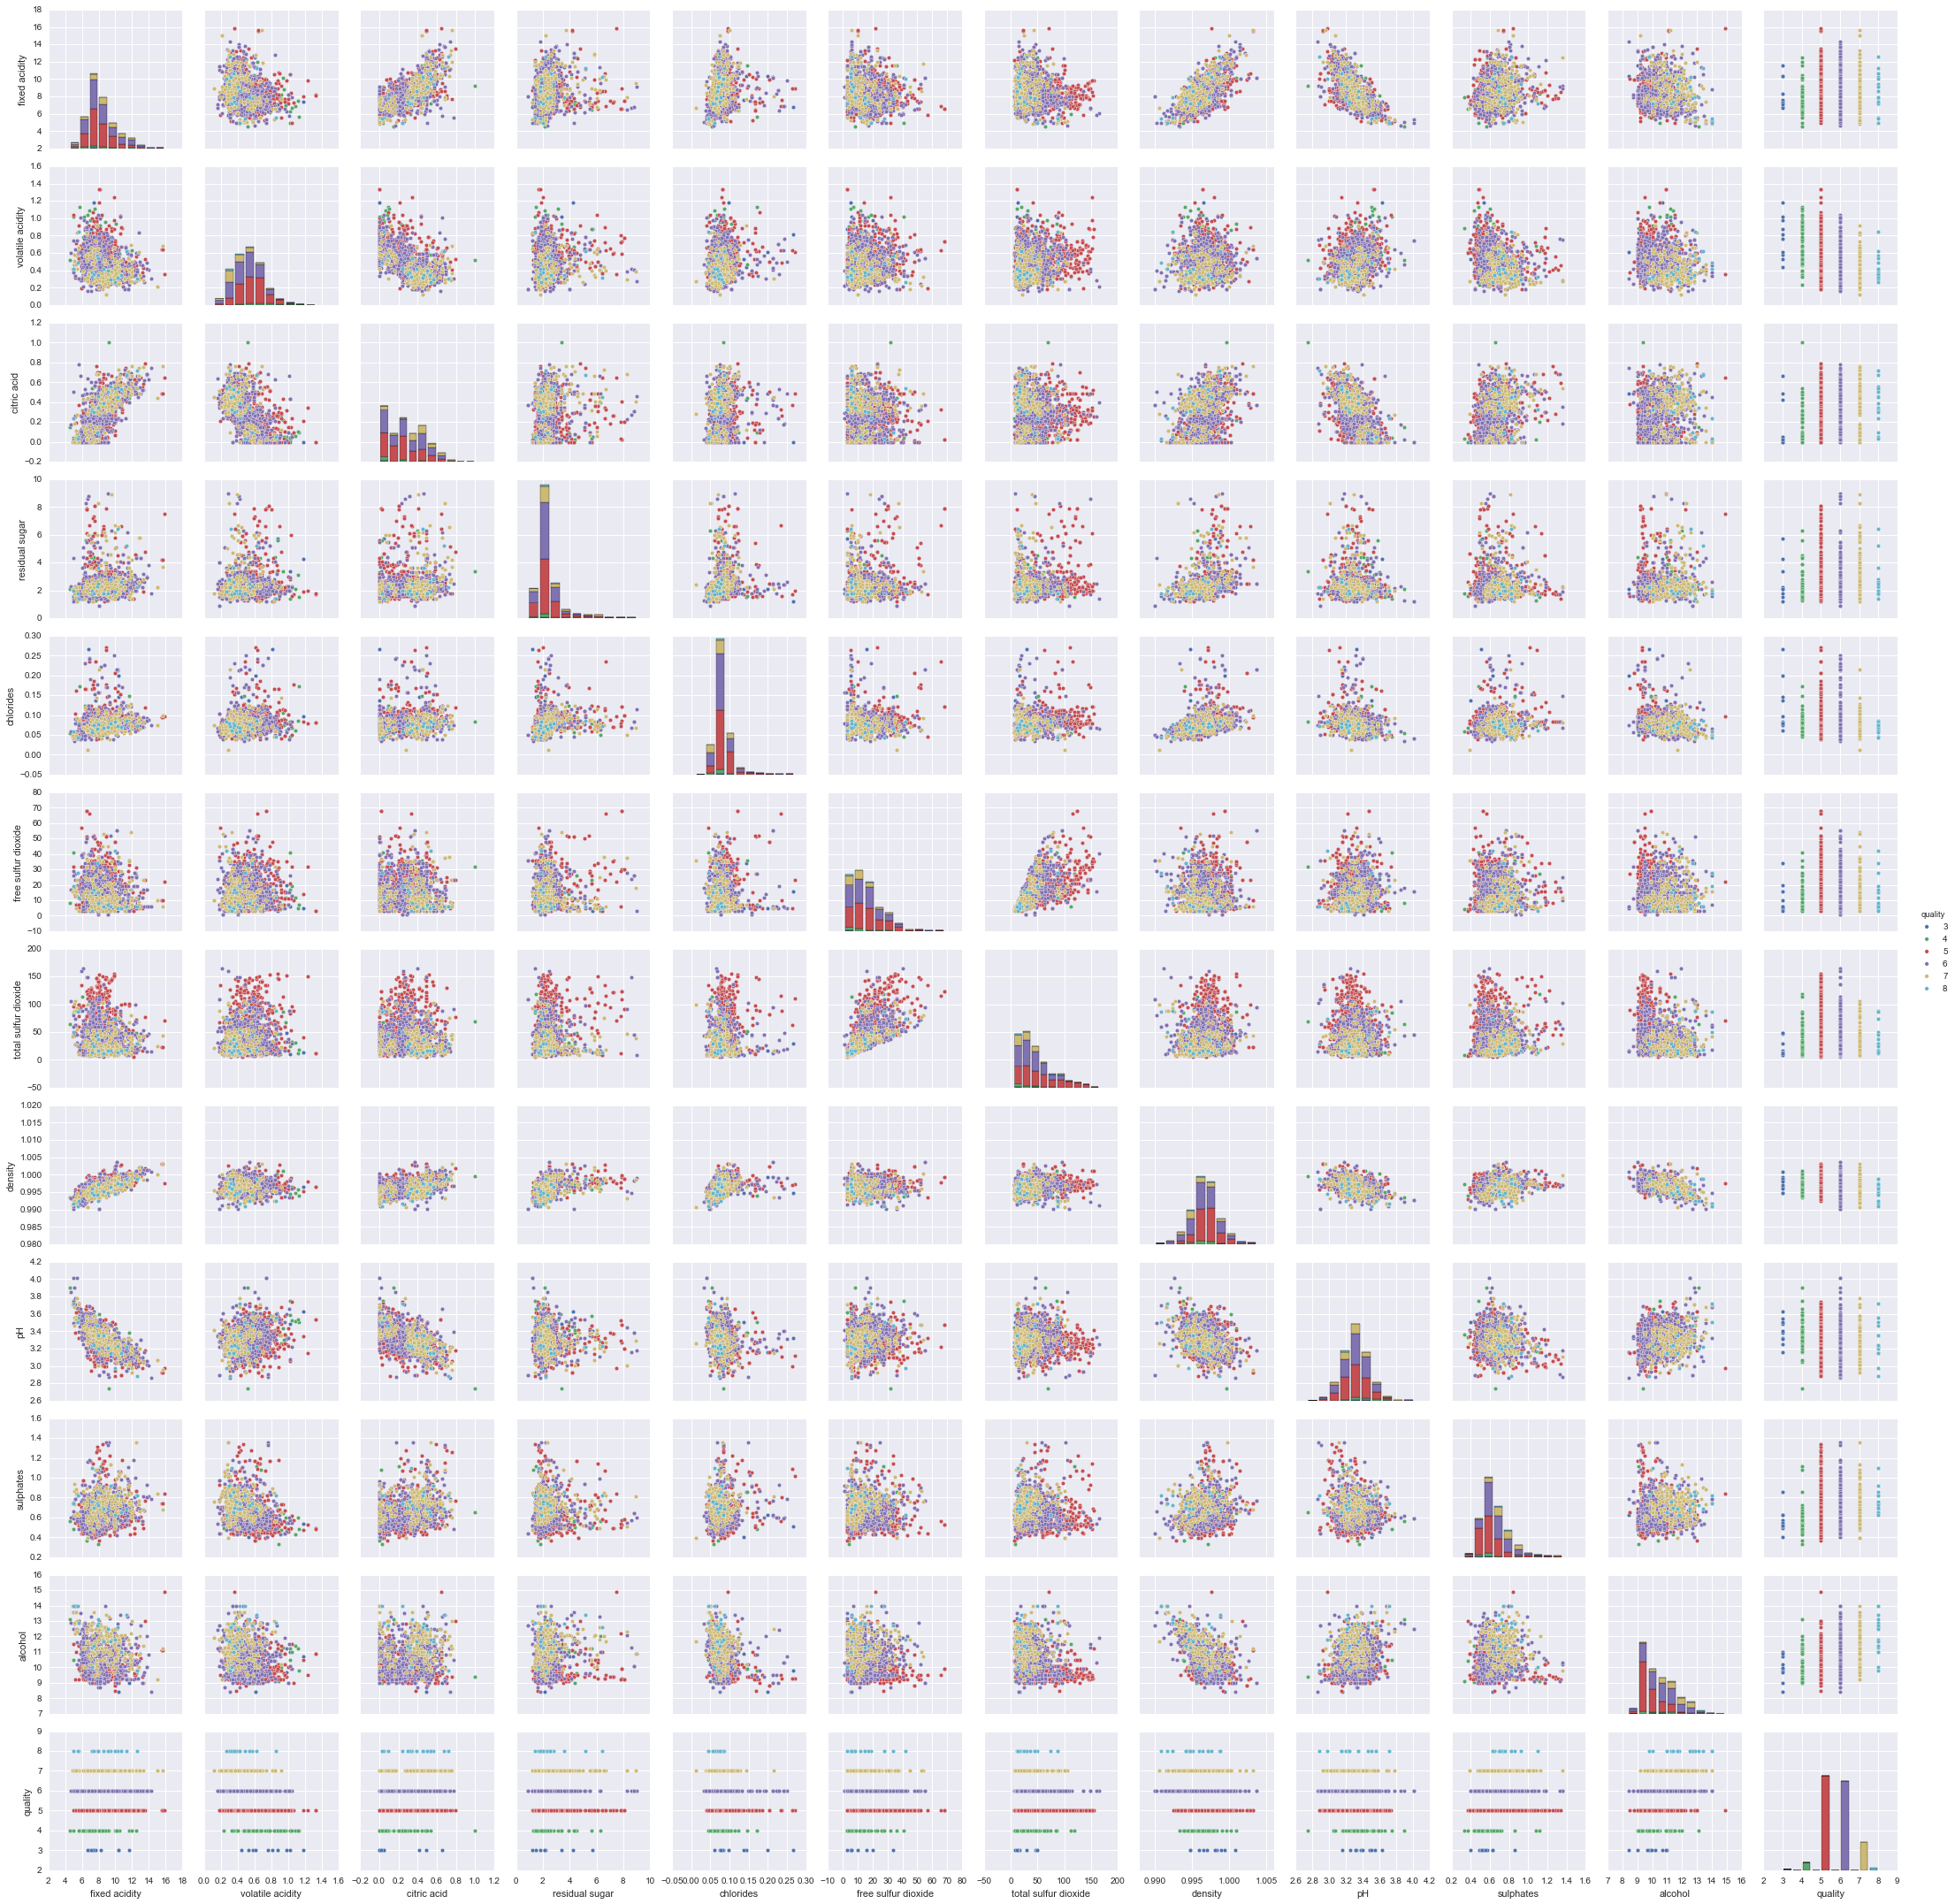

In [9]:
sb.pairplot(red_wine_cleaned, hue='quality')

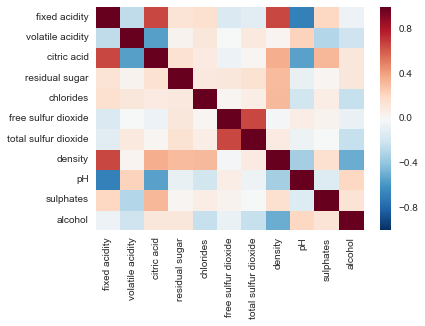

In [10]:
sb.heatmap(red_wine_cleaned.drop(['quality'],1).corr())

In [11]:
red_wine_trimmed_qualities = red_wine_cleaned.copy()
for q in qualities_to_drop:
    red_wine_trimmed_qualities = red_wine_trimmed_qualities[red_wine_trimmed_qualities.quality != q]

In [12]:
red_wine_trimmed_features = red_wine_trimmed_qualities.copy()
red_wine_trimmed_features.drop(features_to_drop, axis=1, inplace=True)

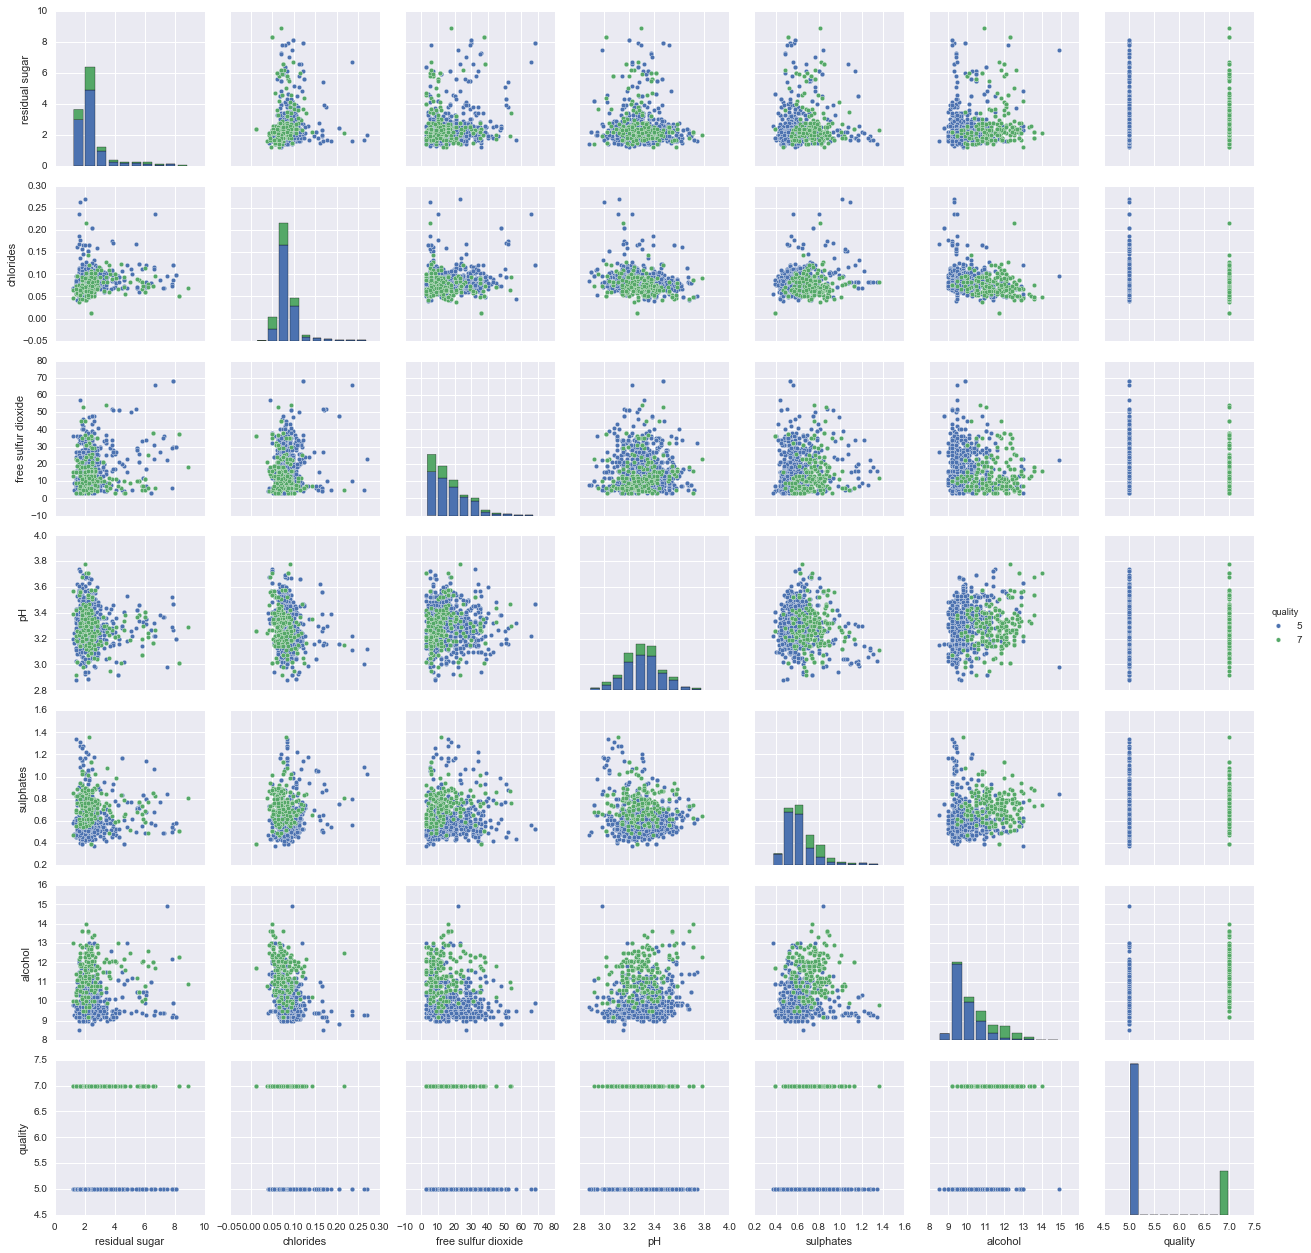

In [13]:
sb.pairplot(red_wine_trimmed_features, hue='quality')

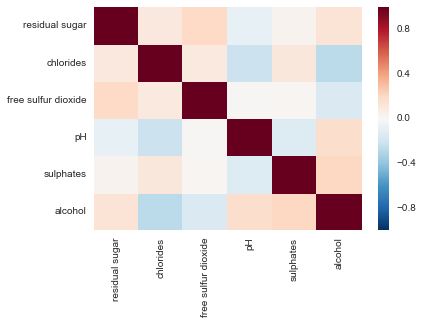

In [14]:
sb.heatmap(red_wine_trimmed_features.drop(['quality'],1).corr())

Set up TensorFlow model

In [15]:
X_red_wine = red_wine_trimmed_features.drop('quality', axis=1)

In [16]:
y_red_wine_series = red_wine_trimmed_features['quality']

In [17]:
number_of_features = len(X_red_wine.columns)
number_of_classes = len(y_red_wine_series.unique())

In [18]:
print("There are {} features, which are: {}.".format(number_of_features, X_red_wine.columns.get_values()))
print("There are {} classes, which are: {}.".format(number_of_classes, np.sort(y_red_wine_series.unique()).tolist()))

There are 6 features, which are: ['residual sugar' 'chlorides' 'free sulfur dioxide' 'pH' 'sulphates'
 'alcohol'].
There are 2 classes, which are: [5, 7].


In [19]:
def replace_labels(label_series):
    labels_to_replace = np.sort(label_series.unique()).tolist()
    replace_with = np.arange(len(labels_to_replace)).tolist()
    new_series = label_series.replace(to_replace=labels_to_replace, value=replace_with)
    
    return new_series

In [20]:
y_red_wine_list = replace_labels(y_red_wine_series).tolist()

In [21]:
def dense_to_one_hot(labels_dense, num_classes=3):
    # Convert class labels from scalars to one-hot vectors
    num_labels = len(labels_dense)
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense] = 1
    return labels_one_hot

In [22]:
y_one_hot = dense_to_one_hot(y_red_wine_list, num_classes=number_of_classes)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_red_wine, y_one_hot, test_size=0.1, random_state=42)

In [24]:
X = tf.placeholder("float", [None, number_of_features])
Y = tf.placeholder("float", [None, number_of_classes])

In [25]:
W = tf.Variable(tf.zeros([number_of_features, number_of_classes]))
b = tf.Variable(tf.zeros([number_of_classes]))

In [26]:
model = tf.nn.softmax(tf.matmul(X, W) + b)

In [27]:
cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(model), reduction_indices=[1]))

In [28]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [35]:
with tf.Session() as sess:
    
    tf.initialize_all_variables().run()

    for i in range(1000):
        average_cost = 0
        number_of_batches = int(len(X_train) / batch_size)
        for start, end in zip(range(0, len(X_train), batch_size), range(batch_size, len(X_train), batch_size)):
            # print(X_train[start:end])
            sess.run(optimizer, feed_dict={X: X_train[start:end], Y: y_train[start:end]})
            # Compute average loss
            average_cost += sess.run(cost, feed_dict={X: X_train[start:end], Y: y_train[start:end]}) / number_of_batches
        # print("Epoch:", '%04d' % (i+1), "cost=", "{:.9f}".format(average_cost))
    
    print('Finished optimization!')
    
    correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(y_test, 1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy: {0}".format(sess.run(accuracy, feed_dict={X: X_test, Y: y_test})))

Finished optimization!
Accuracy: 0.852272748947
